## Install & Import Libraries

In [1]:
!pip install pandas sqlalchemy matplotlib seaborn

import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

## Load, Store, and Clean Data

In [2]:
import os
print("Current working directory:", os.getcwd())
print("\nFiles in this directory:")
print(os.listdir())

Current working directory: /Users/waledrashid/Desktop/EDA_Project

Files in this directory:
['README.md', 'vgsales.db', '.git', 'analysis.ipynb']


In [3]:
data_path = '../vgsales.csv'

try:
    df_raw = pd.read_csv(data_path)
    print("Raw data loaded successfully:")
    print(df_raw.head())
    
    # 2. store data in sqLite
    engine = create_engine('sqlite:///vgsales.db', echo=False)
    
    df_raw.to_sql('sales', con=engine, if_exists='replace', index=False)
    
    print("\nData successfully saved to 'vgsales.db'")

except Exception as e:
    print(f"An error occurred during loading/storing: {e}")


# 3. Load from database and clean
try:
    engine = create_engine('sqlite:///vgsales.db')
    
    df = pd.read_sql_table('sales', con=engine)
    
    # Drop rows where 'Year' is missing
    df_cleaned = df.dropna(subset=['Year'])

    # Correct data type for 'Year'
    df_cleaned['Year'] = df_cleaned['Year'].astype(int)

    print("\nCleaned data head:")
    print(df_cleaned.head())

except Exception as e:
    print(f"An error occurred during cleaning: {e}")

Raw data loaded successfully:
   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  

Data successfully saved to 'vgsales.db'

Cleaned data head:
   Rank                      Name Platform  Year         Genre Publisher  

/var/folders/55/qbwh2b9n50n8zndjvpvgwj000000gn/T/ipykernel_84659/3778394508.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)


## Bar chart - Comparison (Genres)

To test our hypothesis that 'Action' and 'Sports' are the top-selling genres in Europe.

Top 5 Genres in Europe (Millions of Sales):
Genre
Action     516.48
Sports     371.34
Shooter    310.45
Racing     236.32
Misc       213.82
Name: EU_Sales, dtype: float64


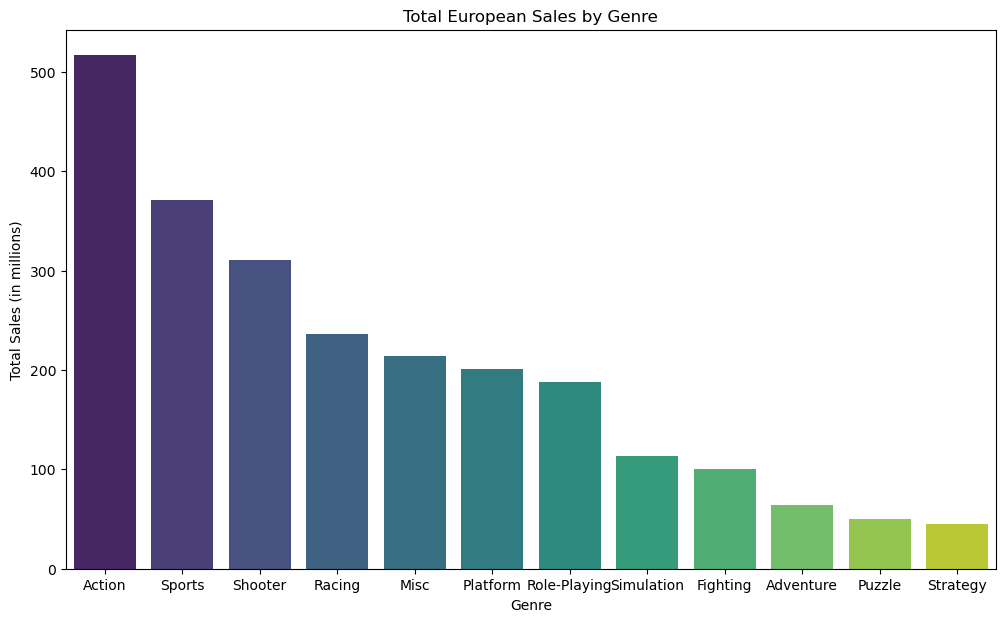

In [4]:
# Group the data by 'Genre' and sum the sales for Europe
genre_sales = df_cleaned.groupby('Genre')['EU_Sales'].sum().sort_values(ascending=False)

print("Top 5 Genres in Europe (Millions of Sales):")
print(genre_sales.head(5))

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette='viridis')

plt.title('Total European Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales (in millions)')
plt.show()

## Horizontal bar chart - Comparison (Platforms)

To test my hypothesis that PlayStation platforms are the most dominant in Europe.

Top 5 Platforms in Europe (Millions of Sales):
Platform
PS3     340.47
PS2     332.63
X360    278.01
Wii     264.35
PS      212.38
Name: EU_Sales, dtype: float64


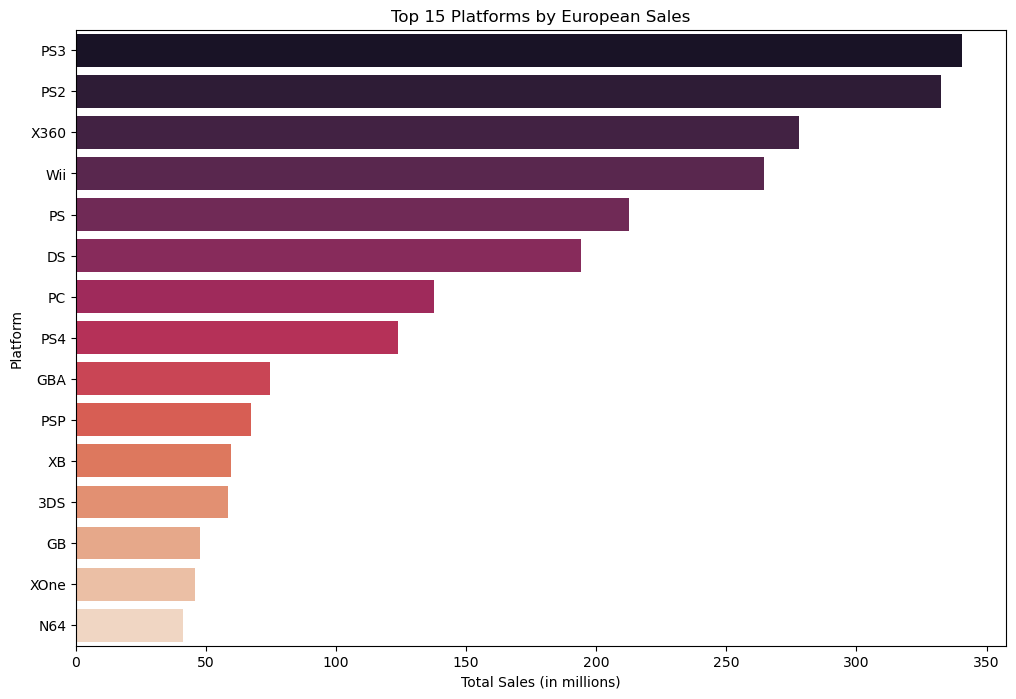

In [5]:
# To group the data by 'Platform' and sum the sales for Europe
platform_sales = df_cleaned.groupby('Platform')['EU_Sales'].sum().sort_values(ascending=False)

# To display the top 5 as text
print("Top 5 Platforms in Europe (Millions of Sales):")
print(platform_sales.head(5))

plt.figure(figsize=(12, 8))
sns.barplot(x=platform_sales.head(15).values, y=platform_sales.head(15).index, palette='rocket')

plt.title('Top 15 Platforms by European Sales')
plt.xlabel('Total Sales (in millions)')
plt.ylabel('Platform')
plt.show()

## Line Plot Graph - Change Over Time

To analyse the trend of total video game sales in Europe over the years.

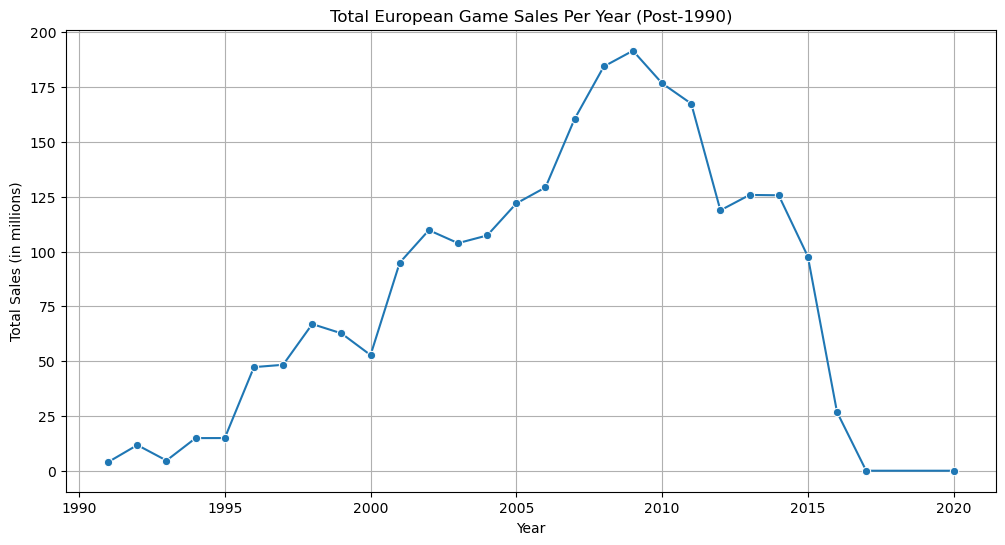

In [6]:
# grouping the data by 'Year' and sum the sales
yearly_sales = df_cleaned.groupby('Year')['EU_Sales'].sum()
yearly_sales_filtered = yearly_sales[yearly_sales.index > 1990]

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_sales_filtered.index, y=yearly_sales_filtered.values, marker='o')


plt.title('Total European Game Sales Per Year (Post-1990)')
plt.xlabel('Year')
plt.ylabel('Total Sales (in millions)')
plt.grid(True)
plt.show()

## Scatter Plot - Relationship

To analyse if a game's sales in Europe are related to its sales in North America.

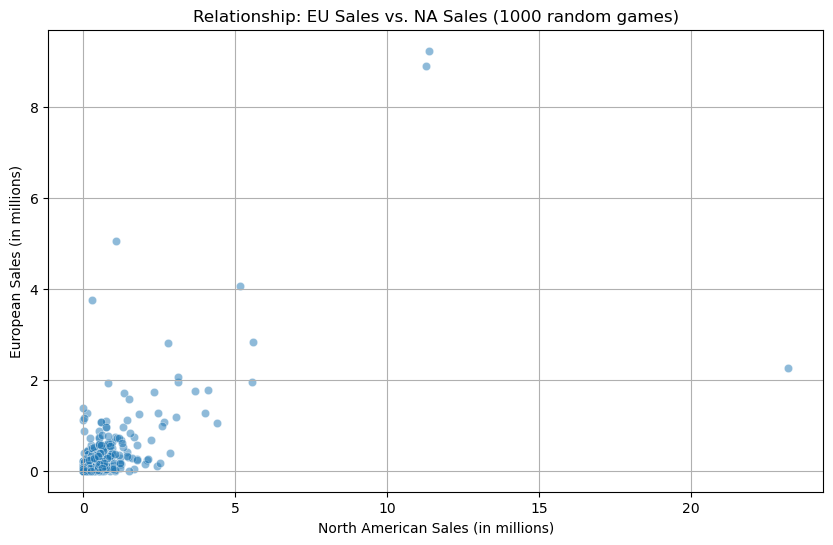

In [7]:
# Took a random sample of 1000 games
df_sample = df_cleaned.sample(n=1000, random_state=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x='NA_Sales', y='EU_Sales', alpha=0.5)

plt.title('Relationship: EU Sales vs. NA Sales (1000 random games)')
plt.xlabel('North American Sales (in millions)')
plt.ylabel('European Sales (in millions)')
plt.grid(True)
plt.show()

## Conclusion & Analysis

My Hypothesis: In Europe, PlayStation platforms have been the most dominant. I also predict that the 'Sports' and 'Action' genres are the highest-selling genres in this region.


## Analysis of Results

Part 1: Genre Preference (Action & Sports)
    First bar chart ("Total European Sales by Genre") shows that 'Action' is the #1 highest-selling genre in Europe.
    'Sports' is the #2 highest-selling genre.
    Conclusion: hypothesis was correct.

Part 2: Platform Dominance (PlayStation)
     Second bar chart ("Top 15 Platforms") shows that the PS2 is the #1 best-selling platform in Europe.
     The PS3 is #2.
     The PC comes in at #3.
     The PS4 is #5.
     Conclusion: hypothesis was correct. PlayStation platforms (PS2, PS3, PS4) hold three of the top five spots and are the most dominant platforms in Europe.

## Web Scraping

To validate my data, I will scrape from Wikipedia list of best-selling game consoles

In [8]:
!pip install lxml html5lib

In [9]:
import pandas as pd
import requests

url = "https://en.wikipedia.org/wiki/List_of_best-selling_game_consoles"

# kept getting a 403 Forbidden error, wikipedia was blocking python scripts.
# added a "User Agent" header so the script looks like a web browser.
# used headers to disguise script
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, headers=headers)
tables = pd.read_html(response.text)
df_wiki = tables[0]

# wikipedia currently uses 'Platform' instead of 'Console'
df_wiki = df_wiki.rename(columns={
    'Platform': 'Platform_Name',     # changed from 'Console' to 'Platform'
    'Released': 'Release_Year',
    'Units sold': 'Global_Sales_Wiki'
})

print("Columns are now:", df_wiki.columns)
print(df_wiki.head())

Columns are now: Index(['Platform_Name', 'Type', 'Company',
       'Released.mw-parser-output .citation{word-wrap:break-word}.mw-parser-output .citation:target{background-color:rgba(0,127,255,0.133)}[2]',
       'Global_Sales_Wiki', 'Ref.'],
      dtype='object')
               Platform_Name      Type   Company  \
0              PlayStation 2      Home      Sony   
1                Nintendo DS  Handheld  Nintendo   
2          Nintendo Switch #    Hybrid  Nintendo   
3  Game Boy & Game Boy Color  Handheld  Nintendo   
4            PlayStation 4 #      Home      Sony   

  Released.mw-parser-output .citation{word-wrap:break-word}.mw-parser-output .citation:target{background-color:rgba(0,127,255,0.133)}[2]  \
0                                               2000                                                                                       
1                                               2004                                                                                       
2  

## Cleaning the scraped data

In [10]:
df_clean = df_wiki.copy()

# cleaning the sales numbers
def clean_wiki_numbers(text):
    text = str(text)
    
    
    if '[' in text:
        text = text.split('[')[0]
        
    # loop through every character. 
    # if number (0-9) or a dot (.), keep it. Otherwise, ignore it.
    allowed_chars = "0123456789."
    clean_text = ""
    
    for char in text:
        if char in allowed_chars:
            clean_text += char
            
    return clean_text

df_clean['Global_Sales_Wiki'] = df_clean['Global_Sales_Wiki'].apply(clean_wiki_numbers)

# to convert to float
df_clean['Global_Sales_Wiki'] = pd.to_numeric(df_clean['Global_Sales_Wiki'], errors='coerce')


# cleaning platform names
name_map = {
    'PlayStation 2': 'PS2',
    'PlayStation 3': 'PS3',
    'PlayStation 4': 'PS4',
    'Xbox 360': 'X360',
    'Nintendo DS': 'DS',
    'Game Boy & Game Boy Color': 'GB',
    'Game Boy Advance': 'GBA',
    'Nintendo 3DS': '3DS',
    'PlayStation': 'PS',
    'Xbox': 'XB',
    'PlayStation Portable': 'PSP',
    'Wii U': 'WiiU',
    'Nintendo Switch': 'Switch' 
}

# to clean footnotes from names
df_clean['Platform_Name'] = df_clean['Platform_Name'].str.split('[').str[0]
df_clean['Platform_Name'] = df_clean['Platform_Name'].str.replace('#', '').str.strip()

# renamed using map
df_clean['Platform_Name'] = df_clean['Platform_Name'].replace(name_map)

print("Cleaned Data Sample:")
print(df_clean[['Platform_Name', 'Global_Sales_Wiki']].head(10))

Cleaned Data Sample:
   Platform_Name  Global_Sales_Wiki
0            PS2             160.00
1             DS             154.02
2         Switch             154.01
3             GB             118.69
4            PS4             117.20
5             PS             102.49
6            Wii             101.63
7            PS3              87.40
8  PlayStation 5              84.20
9           X360              84.00


In [11]:
# grouped by platform to get one total number per console
df_original_sales = df_raw.groupby('Platform')['Global_Sales'].sum().reset_index()

# merged two tables together and matched them based on the platform name
df_merged = pd.merge(df_original_sales, df_clean, 
                     left_on='Platform', 
                     right_on='Platform_Name', 
                     how='inner') # 'inner' keeps only consoles that exist in both lists

# to calculate the difference
# wiki sales - original sales = difference
df_merged['Difference'] = df_merged['Global_Sales_Wiki'] - df_merged['Global_Sales']

print("Integration Results (Sorted by Highest Sales):")
print(df_merged[['Platform', 'Global_Sales', 'Global_Sales_Wiki', 'Difference']].sort_values('Global_Sales', ascending=False).head(10))

Integration Results (Sorted by Highest Sales):
   Platform  Global_Sales  Global_Sales_Wiki  Difference
5       PS2       1255.64             160.00    -1095.64
11     X360        979.96              84.00     -895.96
6       PS3        957.84              87.40     -870.44
9       Wii        926.71             101.63     -825.08
1        DS        822.49             154.02     -668.47
4        PS        730.66             102.49     -628.17
3       GBA        318.50              81.51     -236.99
8       PSP        296.28              80.00     -216.28
7       PS4        278.10             117.20     -160.90
12       XB        258.26              24.00     -234.26
